In [27]:
import cv2
import os

from PIL import Image, ImageTk

import matplotlib.pyplot as plt
import numpy as np

import skimage as skim
import pandas as pd
#from sklearn.decomposition import PCA
#from sklearn.preprocessing import StandardScaler

import pickle
import joblib

from pathlib import Path
from tkinter import Tk, Canvas, Button, messagebox

import seaborn as sns

No se capturó ninguna imagen para procesar.
Dimensiones originales: 301x362
Dimensiones redimensionadas: 64x64


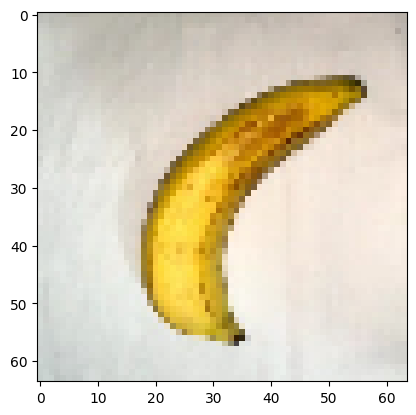

In [28]:
# Variable global para almacenar la ruta de la imagen capturada
ruta_imagen = ""

# Función para capturar y guardar la imagen
def capturar_imagen():
    global cap, ruta_imagen  # Usamos la variable global para almacenar la ruta
    ret, frame = cap.read()
    if ret:
        # Crea la carpeta si no existe
        folder = "captured_images"
        os.makedirs(folder, exist_ok=True)
        
        # Define el nombre del archivo con un índice único
        image_count = len(os.listdir(folder)) + 1
        ruta_imagen = os.path.join(folder, f"imagen_{image_count}.jpg")
        cv2.imwrite(ruta_imagen, frame)
        
        messagebox.showinfo("Captura", f"Imagen guardada en: {ruta_imagen}")
        
        # Cerrar la ventana y liberar la cámara
        cerrar_programa()
    else:
        messagebox.showerror("Error", "No se pudo capturar la imagen.")

# Función para mostrar el video en tiempo real
def mostrar_video():
    global cap, canvas
    ret, frame = cap.read()
    if ret:
        # Convierte el frame a un formato compatible con Tkinter
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = ImageTk.PhotoImage(image=Image.fromarray(frame_rgb))
        canvas.create_image(0, 0, anchor="nw", image=img)
        canvas.image = img  # Mantener referencia para evitar que la imagen sea eliminada
    ventana.after(10, mostrar_video)

# Configura el cierre del programa
def cerrar_programa():
    global cap, ventana
    cap.release()
    ventana.destroy()

# Configuración de la cámara
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Error al abrir la cámara.")
    exit()

# Interfaz gráfica con tkinter
ventana = Tk()
ventana.title("Captura de Imágenes")

# Crea un canvas para mostrar el video
canvas = Canvas(ventana, width=640, height=480)
canvas.pack()

# Botón para capturar la imagen
btn_captura = Button(ventana, text="Capturar Imagen", command=capturar_imagen)
btn_captura.pack(pady=10)

# Configura el cierre del programa
def cerrar_programa():
    cap.release()
    ventana.destroy()

ventana.protocol("WM_DELETE_WINDOW", cerrar_programa)

# Inicia la función para mostrar el video en tiempo real
mostrar_video()

# Inicia la interfaz gráfica
ventana.mainloop()

# Después de capturar la imagen, procesarla
if ruta_imagen:
    IMG_PATH = Path(ruta_imagen)
else:
    print("No se capturó ninguna imagen para procesar.")
    IMG_PATH = Path("./captured_images/prueba2.jpg")
try:        
    size = (64, 64)

    # Leer la imagen
    img = cv2.imread(str(IMG_PATH))

    # Convertir la imagen a RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Redimensionar la imagen
    img_resized = cv2.resize(img, size)

    # Obtener las dimensiones originales y redimensionadas
    height, width = img.shape[:2]
    print(f"Dimensiones originales: {width}x{height}")
    print(f"Dimensiones redimensionadas: {img_resized.shape[1]}x{img_resized.shape[0]}")
except Exception as e:
    print(f"Error al procesar la imagen: {e}")

plt.imshow(img_resized)

In [29]:
def get_hog(img, hog_params):
    return skim.feature.hog(img, **hog_params)


def get_lbp(img, lbp_params):
    lbp = skim.feature.local_binary_pattern(
        cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), **lbp_params
    )

    lbp_hist, _ = np.histogram(
        lbp.ravel(),
        bins=np.arange(0, lbp_params["P"] + 3),
        range=(0, lbp_params["P"] + 2),
        density=True,
    )
    return lbp, lbp_hist

def compute_channel_histogram(
    channel: np.ndarray, bins: int, hist_range: tuple
) -> np.ndarray:
    hist = cv2.calcHist([channel], [0], None, [bins], hist_range)
    return cv2.normalize(hist, hist).flatten()

def get_hsv_color_histograms(
    image: np.ndarray, hsv_hist_params, plot: bool = False, axes=None
) -> np.ndarray:
    # Extraer el parámetro bins o asignarlo por defecto
    bins = hsv_hist_params.get("bins", 50)

    # Convertir espacios de color
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Definir los rangos posibles para cada canal
    hist_params = [
        (hsv_image[:, :, 0], bins, (0, 180), "H"),  # Hue: rango [0, 180]
        (hsv_image[:, :, 1], bins, (0, 256), "S"),  # Saturation: rango [0, 256]
        (hsv_image[:, :, 2], bins, (0, 256), "V"),  # Value: rango [0, 256]
    ]

    # Computar y apilar los histogramas para cada canal
    hsv_features = []
    for i, (channel, b, hist_range, name) in enumerate(hist_params):
        hist = compute_channel_histogram(channel, b, hist_range)
        hsv_features.append(hist)

    return np.hstack(hsv_features)

def extract_features(img: Path, hog_params, lbp_params, hsv_hist_params):
    features = []
    # HOG
    fd = get_hog(img, hog_params)

    # LBP
    lbp, lbp_hist = get_lbp(img, lbp_params)

    # HSV histogram
    hsv_feats = get_hsv_color_histograms(img, hsv_hist_params)
    feature_col = np.hstack((fd.ravel(), lbp_hist, hsv_feats))
    features.append(feature_col)
    
    hog_n = fd.ravel().size
    lbp_n = lbp_hist.size
    hsv_n = hsv_feats.size
    
    features_df = pd.DataFrame(features)
    
    features_df.columns = (
        [f"hog_{i}" for i in range(1, hog_n + 1)]
        + [f"lbp_{i}" for i in range(1, lbp_n + 1)]
        + [f"hsv_{i}" for i in range(1, hsv_n + 1)]
    )
    
    return features_df
    

In [30]:
HOG_PARAMS = {
    "orientations": 8,
    "pixels_per_cell": (16, 16),
    "cells_per_block": (2, 2),
    "visualize": False,
    "channel_axis": -1,
}

radius = 3
LBP_PARAMS = {"R": radius, "P": 8 * radius, "method": "uniform"}
HSV_HIST_PARAMS = {"bins": 50}

features_df = extract_features(img_resized, HOG_PARAMS, LBP_PARAMS, HSV_HIST_PARAMS)

#features_df.columns = features_df.columns.astype(str)

DF_PATH = Path("./img_features_64.csv")
features_df.to_csv(DF_PATH)

In [31]:
features_df

,hog_1,hog_2,hog_3,hog_4,hog_5,hog_6,hog_7,hog_8,hog_9,hog_10,...,hsv_141,hsv_142,hsv_143,hsv_144,hsv_145,hsv_146,hsv_147,hsv_148,hsv_149,hsv_150
0,0.103779,0.030456,0.090524,0.081368,0.114194,0.097194,0.102278,0.044642,0.088367,0.107941,...,0.193108,0.252242,0.291972,0.371433,0.39176,0.336322,0.282733,0.351106,0.315071,0.185716


In [32]:
# Cargar el modelo SVM y el scaler
SVM_PATH = Path('../03_classification/ovr_results/DB 64×64_best_estimator.pkl')
SCALER_PATH = Path('../03_classification/ovr_results/DB 64×64_scaler.pkl')

model = joblib.load(SVM_PATH)
scaler = joblib.load(SCALER_PATH)

# Convertir a numpy array
features_np = features_df.values

# Transformar las características con el scaler cargado
features_scales = scaler.transform(features_np)

# Realizar la predicción
prediccion = model.predict(features_scales)
print(f"Predicción: {prediccion[0]}")

Predicción: 7.0


c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
